In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import namedtuple
import importlib
from workalendar.registry import registry
from datetime import date
from datetime import datetime, timedelta
import model.copula_package as copula

In [16]:
#  ALL TESTING DAYS
CalendarClass = registry.get('CH-VD')
calendar = CalendarClass()

test_date = pd.to_datetime(datetime(2019,1,15,0,0,0), utc=True)
test_dates = []
for i in range(0,1):
    temp = test_date+timedelta(days=i)
    test_dates.append(temp)
    
test_dates

[Timestamp('2019-01-15 00:00:00+0000', tz='UTC')]

# Forecast parameters

In [21]:
def create_params(data_id, h_fixed):
    params = {'forecast_horizon': 96, # 152 for 10am
              'fixed_lags': [96*7],
              'find_bandwidth':False,
              'optimization_objective':'pl_multi', # 'ise', 'pl', 'pl_multi', 'crps' or 'crps_multi' (Integrated square error, pinball-loss, multistep pinball-loss or continuous rank probability score)
              'fixed_bandwidths' : False,
              'L': 500,
              'include_weekday':False,
              'include_temperature':True,
              'split_weekend_weekday':False,
              'remove_mean':False,
              'include_ghi':False,
              'saturday_is_weekday':False,
              'detrend_timeseries':False,
              'plot_string': 'Forecast using empirical copula',
              'nb_scenario':1,
              'x0': None,
              'output': None, # if output = 'scenarios' code is much slower
              'nb_output_scenarios' : 3000,
              'power_unit': 'kW',
              'h': h_fixed,
              'data_id' : data_id,
              'rule_of_thumb_bandwidth' : False
             }
    copula_params = namedtuple('params', params)
    params = copula_params(**params)
    return params

# Perform forecast

Precalculated bandwidths available


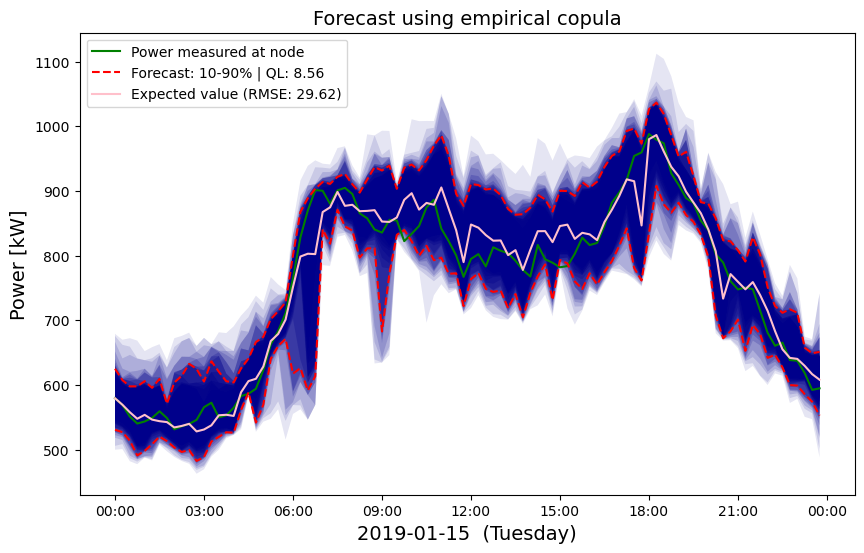

In [22]:
importlib.reload(copula)

buildings = [24] # all
for building in buildings:
    # Function to load the dataset
    dataset, data_id = copula.load_data(id_data=building)
    params = create_params(data_id, h_fixed=None)
    
    # Location to store the generated forecasts
    loc = r'generated_forecasts/ec/'
    
    nb_scenario = 1
    for i in range(0,nb_scenario):
        for j, sel_date in enumerate(test_dates):

            # If custom bandwidths
            #params = create_params(data_id, h_fixed=np.array(h[j]))
            
            save_string = f'forecast_{params.data_id}_horizon-{params.forecast_horizon}'
            results, rel_params = copula.run_prediction(dataset, sel_date, params)
            if(params.find_bandwidth):
                if((params.optimization_objective == 'pl_multi') or (params.optimization_objective == 'crps_multi')):
                    continue
            
            # Visualize results
            copula.show(results, rel_params, params)
                        
            # Store results
            np.save(f'{loc}{save_string}_forecast_quantiles_{str(sel_date.date())}', results['forecast'])
            np.save(f'{loc}{save_string}_targets_{str(sel_date.date())}', results['target'])
            np.save(f'{loc}{save_string}_expected-values_{str(sel_date.date())}', results['expected_value'])
            
            # If scenarios is used, store the distribution samples
            if(params.output=='scenarios'):
                np.save(f'{loc}{save_string}_raw-data_scen{i}_{str(sel_date.date())}', rel_params)